# User Process Data Exploration With dmx-learn

This notebook demonstrates how to try out several different models for sequences of heterogeneous data with varying length sizes. In this notebook, we attempt to build a model to find the alias of a new user.

In [ ]:
from dmx.stats import *
from dmx.utils.estimation import optimize, best_of
import numpy as np
import pickle
import os
import pandas as pd
import json
from numpy.random import RandomState

import matplotlib.pyplot as plt

PATH_TO_DATA = "../data/process_sequences"
TRAIN_DATA = os.path.join(PATH_TO_DATA, "process_sequence_train.csv")
TEST_DATA = os.path.join(PATH_TO_DATA, "process_sequence_test.csv")

rng = RandomState(10)

In [3]:
def load_data() -> tuple[pd.DataFrame, list[tuple[float, str]]]:
    
    # read in the training data
    train_df = pd.read_csv(TRAIN_DATA)
    train_df['process_sequence'] = train_df['process_sequence'].apply(json.loads)
    train_df['process_sequence'] = train_df['process_sequence'].apply(lambda x: [tuple(item) for item in x])

    # read in new user data to predict
    test_df = pd.read_csv(TEST_DATA)
    test_df['process_sequence'] = test_df['process_sequence'].apply(json.loads)
    test_df['process_sequence'] = test_df['process_sequence'].apply(lambda x: [tuple(item) for item in x])

    target = [x for x in test_df["process_sequence"].values]

    return train_df, target

df, target = load_data()


In [4]:
df.head()

,user_id,process_sequence
0,user_0,"[(16.03175219059731, process_47), (15.26864274..."
1,user_0,"[(16.111294816876303, process_5), (9.496040580..."
2,user_0,"[(14.099651147002815, process_28), (30.9002646..."
3,user_0,"[(11.642859125642342, process_11), (17.7635657..."
4,user_0,"[(41.51333438268455, process_31), (18.57012327..."


Examining the first few entries for "user_0" we see that we have `list[tuple[float, str]]` of varying sizes for each process sequence entry. 

In [12]:
for i in range(5):
    print(f"Entry {i}: process_sequence length is {len(df['process_sequence'].values[i])}")

Entry 0: process_sequence length is 6
Entry 1: process_sequence length is 7
Entry 2: process_sequence length is 6
Entry 3: process_sequence length is 6
Entry 4: process_sequence length is 7


### User and Document Counts

Next, we will determine how many unique users are present in the dataset and examine the number of documents associated with each user.

In [15]:
user_ids = df["user_id"].unique()
num_users = len(user_ids)
print(f"There are {num_users} unique users.")

There are 100 unique users.


#### Top and Bottom Users by Document Count
We'll also count the number of unique entries per user to get an idea of how well each user is represented in the training set. 

We can print out the top 10 users with the most documents and the bottom 10 users with the fewest documents. This helps us understand the distribution of documents across users in the dataset.

In [28]:
user_doc_cnt = dict(sorted(df["user_id"].value_counts().to_dict().items(), key=lambda item: int(item[0].split("_")[1])))

line_str = ["".join(["-"]*50)]
print("\n".join(["Top 10 Document Counts"] + line_str + [f"{k}: {v}" for k, v in list(user_doc_cnt.items())[-10:]]))
print("\n")
print("\n".join(["Bottom 10 Document Counts"] + line_str + [f"{k}: {v}" for k, v in list(user_doc_cnt.items())[:10]]))

Top 10 Document Counts
--------------------------------------------------
user_90: 52
user_91: 44
user_92: 38
user_93: 43
user_94: 45
user_95: 37
user_96: 48
user_97: 39
user_98: 41
user_99: 41


Bottom 10 Document Counts
--------------------------------------------------
user_0: 38
user_1: 54
user_2: 49
user_3: 39
user_4: 40
user_5: 38
user_6: 43
user_7: 37
user_8: 34
user_9: 32


It looks like we have a fair amount of samples for each user. There should be any concern with under-represented user data. 

## Modeling with Combinators in dmx-learn

In this section, we will use dmx-learn's combinators to build an estimator for our sequence data. Our goal is to construct a model that can identify which user is most likely to have generated the target sequence.

We will break this process down into the following steps:

1. **Pick an estimator for the process times.**
2. **Pick a distribution for the process names.**
3. **Select an appropriate combinator for the sequences.**
4. **Pick a combinator that allows us to model by user.**
5. **Estimate the model and attempt to perform inference.**

We will write out our training data to `tuple[str, list[tuple[float, str]]]` to build up a distribution in `dmx-learn`. This ensures each `user_id` is paried with the corresponding `process_sequence`.

In [34]:
def get_data_from_dataframe(df) -> list[tuple[str, list[tuple[float, str]]]]:
    data = []
    for x in df.itertuples():
        data.append((x[1], [w for w in x[2]]))
    
    return data

data = get_data_from_dataframe(df)

### Step 1: Pick an Estimator for the Process Times

Let's start by visualizing the process times to better understand their distribution. This will help us choose an appropriate estimator for modeling the process times.

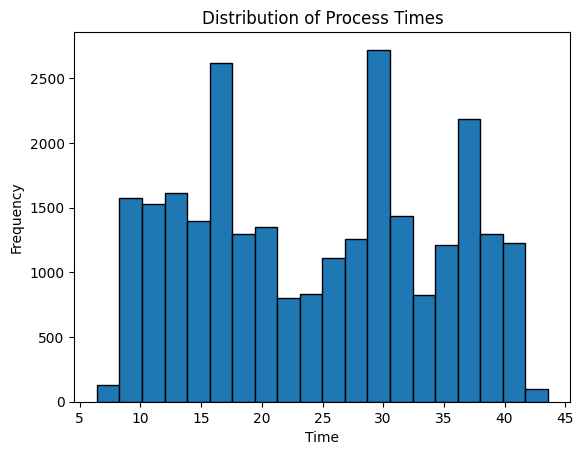

In [35]:
times = [xx[0] for _, x in data for xx in x]
plt.hist(times, bins=20, edgecolor='black')
plt.title("Distribution of Process Times")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

Although the data is not Gaussian, we will simply pick a Gaussian estimator for the time being. Later on, we can consider a better option that fits the data more closely. We can assign the estimator as follows:

In [36]:
est_time = GaussianEstimator()

### Step 2: Pick an Estimator for the Process Names

Let's start by getting all the process names and seeing how many there are. Then we can define an estimator for the data type.

In [37]:
process_names = sorted(list(set([y[1] for _, x in data for y in x])), key=lambda u: int(u.split("_")[-1]))
print(f"Names range from: {process_names[0]}...{process_names[-1]}")

Names range from: process_0...process_49


We can simply define a `CategoricalEstimator` for the process names.

In [39]:
est_procs = CategoricalEstimator()

### Step 3: Use Combinators to Build a Distribution for a Sequence of Tuples

Now we need to use the Combinators to build a distribution for a sequence of (process time, process name) tuples. This will allow us to model the sequential nature of the data, capturing both the order and the structure of each user's process sequence.

First we can define a `CompositeEstimator` to handle the tuple of process time and process name. 

In [40]:
est_tuple = CompositeEstimator([est_time, est_procs])

Since we have sequences of varying lengths for each user, we can take a look at what the length distribution may look like. 

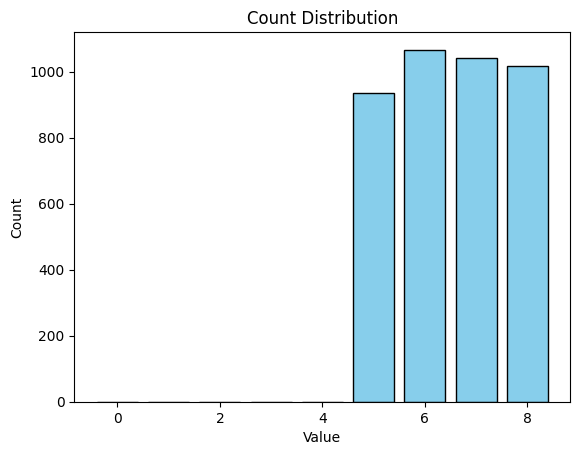

In [41]:
proc_lengths = np.bincount([len(x) for _, x in data])
plt.bar(np.arange(len(proc_lengths)), proc_lengths, color='skyblue', edgecolor='black')
plt.xlabel("Value")
plt.ylabel("Count")
plt.title("Count Distribution")
plt.show()


It looks like all the lengths are in the range of 5-8, so we can pick an `IntegerCategoricalEstimator` and set the `min_val` parameter. Note that this does not really matter, as it is estimated later on regardless. We can pass this length estimator along with the tuple estimator into a `SequenceEstimator` to create our estimator for process sequences.

In [42]:
len_est = IntegerCategoricalEstimator(min_val=5, max_val=8)
est_proc_seqs = SequenceEstimator(estimator=est_tuple, len_estimator=len_est)

# Step 4: Define an estimator to fit a model for each user. 

For this we will simply use the `ConditionalDistributionEstimator`. We know that we have 100 users, so we can simply define an `estimator_map` dictionary that takes an estimator for the process data for each user id. 

In [43]:
est = ConditionalDistributionEstimator(estimator_map={k: est_proc_seqs for k in user_ids})

# Step 5: Estimate the model from our data.

We built an appropriate estimator for the observed data. Now we can use optimize to fit the model. 

In [44]:
# well we have an estimator, but is it any good?

mm = optimize(
    data=data,
    estimator=est,
    rng=np.random.RandomState(43),
    max_its=1000,
    delta=1.0e-6,
    print_iter=25,
    init_p=1.0
)

Iteration 1: ln[p_mat(Data|Model)]=-1.988737e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=0.000000e+00


Lets evaluate the log-likelihood for each user model at the target user observations. 

In [45]:
ll = np.zeros((100, len(target)))
# this encodes the data. It allows for fast numeric calls to functions like .seq_...
enc_target = seq_encode(target, model=mm.dmap["user_0"])[0][1]
# Evaluate the log-density for each of the 100 user models at each of the 5 target observations.
for i in range(100):
    ll[i] += mm.dmap[f"user_{i}"].seq_log_density(enc_target)


Let's take a peak at our log-likelihoods from the model for user 0.

In [46]:
ll[0]

array([        -inf, -59.39493353, -65.09013856, -68.96275769,
               -inf])

In this next step, we will access the model for $P(X \mid \text{user}_0)$ that we have fit. We'll examine the distributions produced by the sequence model for this user, focusing specifically on the process ID component. This will help us check if there are any unexpected or unusual patterns in the process ID model for user 0.

In [47]:
# hmm it looks like we are getting -inf for some values? Lets take a look at what is going on here
# Model for P(X | user_0)
user_0_dist = mm.dmap["user_0"]
# Model from the sequence distribution
tuple_user_0 = user_0_dist.dist
# Get the model for the processes
proc_user_0 = tuple_user_0.dists[1]
non_zero_procs_0 = sorted([k for k in proc_user_0.pmap.keys()], key=lambda x: int(x.split("_")[1]))

In [48]:
# take a look at target 0
target[0]

[(35.401825640807715, 'process_40'),
 (35.82831093114166, 'process_38'),
 (23.422441225225555, 'process_46'),
 (11.054475987002732, 'process_32'),
 (18.918797018676127, 'process_15'),
 (20.839533987317157, 'process_41')]

In [49]:
print(f"Was process_40 ever used by user_0 in the training data: {"process_40" in non_zero_procs_0}")

Was process_40 ever used by user_0 in the training data: False


The above tells us that building a conditional model for each user is too rigid. It is possible that a user never used a single process but may still be a viable candidate for a match. We'll need to incorporate some more information into our model to handle this.

In [56]:
est_time = GaussianEstimator()
# flattening with suff_stat
est_procs = CategoricalEstimator(pseudo_count=1.0, suff_stat={pname: 1/len(process_names) for pname in process_names})
est_tuple = CompositeEstimator([est_time, est_procs])

# put a key on the length distribution so everyone has the same lenght distribution
len_est = IntegerCategoricalEstimator(min_val=5, max_val=8, keys="length_dist")
est_proc_seqs = SequenceEstimator(estimator=est_tuple, len_estimator=len_est)

# Define the conditional estimator again
est = ConditionalDistributionEstimator(estimator_map={k: est_proc_seqs for k in user_ids})

In [57]:
# well we have an estimator, but is it any good?

mm = optimize(
    data=data,
    estimator=est,
    rng=np.random.RandomState(43),
    max_its=1000,
    delta=1.0e-6,
    print_iter=25,
    init_p=1.0
)

Iteration 1: ln[p_mat(Data|Model)]=-1.990338e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=0.000000e+00


In [58]:
ll = np.zeros((100, len(target)))
# this encodes the data. It allows for fast numeric calls to functions like .seq_...
enc_target = seq_encode(target, model=mm.dmap["user_0"])[0][1]
# Evaluate the log-density for each of the 100 user models at each of the 5 target observations.
for i in range(100):
    ll[i] += mm.dmap[f"user_{i}"].seq_log_density(enc_target)

print(f"Are any log-likelihoods -np.inf: {np.any(np.isinf(ll))}")


Are any log-likelihoods -np.inf: False


It looks like this fixed our issue with having 0 valued densities. Lets use the likelihoods from each model to order the most likely user aliases. 

In [59]:
conditional_top_5 = np.argsort(-ll, axis=0)[:5, :]

for i in range(5):
    print(f"Top 5 for document {i}: {conditional_top_5[:, i].tolist()}")

Top 5 for document 0: [60, 84, 83, 98, 7]
Top 5 for document 1: [72, 8, 24, 34, 60]
Top 5 for document 2: [72, 8, 24, 3, 68]
Top 5 for document 3: [8, 72, 16, 11, 17]
Top 5 for document 4: [14, 61, 1, 54, 83]


# Using Composite Mixtures

Now we are going to try building a model using a composite mixture approach. This will allow us to compare the results with our previous models and see if the composite mixture provides any improvements or new insights.

In this approach, we will fit a composite mixture model where the topics (mixture components) are shared across all user models. This means that each user is modeled as a mixture over the same set of underlying topics, but the mixture weights (i.e., how much each topic contributes) are allowed to vary for each user. The structure of the topics themselves—such as the distributions over process times and process names—remains identical for every user. Only the way each user combines these topics (their mixture weights) is different.


We start off by defining the same estimators for process time and process names as before. We will keep the flattening on the process name estimator. 

In [60]:
est_time = GaussianEstimator()
# flattening with suff_stat
est_procs = CategoricalEstimator(pseudo_count=1.0, suff_stat={pname: 1/50. for pname in process_names})
est_tuple = CompositeEstimator([est_time, est_procs])

Now we will define a composite mixture and key the mixture components. This will ensure that each user model shares the same topics. 

In [61]:
# We can key the mixture components to ensure each user model will have the same topics.
est_mix = MixtureEstimator([est_tuple]*5, keys=(None, "mix_comps"))

We can use the same combinators for the sequence and conditional wrapper as before. This defines a user-conditional mixture model for process sequences of varying sizes where each model has the same topics!

In [62]:
# put a key on the length distribution so everyone has the same lenght distribution
len_est = IntegerCategoricalEstimator(min_val=5, max_val=8, keys="length_dist")
est_proc_seqs = SequenceEstimator(estimator=est_mix, len_estimator=len_est)

# Define the conditional estimator again
est = ConditionalDistributionEstimator(estimator_map={k: est_proc_seqs for k in user_ids})

Estimation is similar to before. This time we need to estimate weights via EM, so it will take a bit more time to fit the model. 

In [63]:
mm = optimize(
    data=data,
    estimator=est,
    rng=np.random.RandomState(4),
    max_its=1000,
    delta=1.0e-6,
    print_iter=25,
    init_p=0.10
)

Iteration 25: ln[p_mat(Data|Model)]=-1.776773e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.133673e+01
Iteration 50: ln[p_mat(Data|Model)]=-1.776545e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.011346e-04
Iteration 55: ln[p_mat(Data|Model)]=-1.776545e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=-4.431640e-07


We can compute the likelihood for each target sequence under each user model as before. We shouldn't encounter any zero-likleihoods.

In [64]:
ll = np.zeros((100, len(target)))
enc_target = seq_encode(target, model=mm.dmap["user_0"])[0][1]

for i in range(100):
    ll[i] += mm.dmap[f"user_{i}"].seq_log_density(enc_target)

print(f"Are any log-likelihoods -np.inf: {np.any(np.isinf(ll))}")

Are any log-likelihoods -np.inf: False


In [66]:
mix_top_5 = np.argsort(-ll, axis=0)[:5, :]

for i in range(5):
    print(f"Top 5 for document {i}: {mix_top_5[:, i].tolist()}")

Top 5 for document 0: [53, 49, 7, 25, 54]
Top 5 for document 1: [72, 8, 28, 48, 16]
Top 5 for document 2: [72, 8, 28, 48, 68]
Top 5 for document 3: [72, 8, 28, 48, 16]
Top 5 for document 4: [48, 28, 49, 16, 11]


The resulting top-5 user aliases for each target document look different. One thing to notice is that users 72 and 8 seem to be making a an appearance in the top-5. We should also note that we chose to ignore any potential sequential dependence in the process sequences. If this information is important, we could build a richer model. We will explore this in the next section. 

# Hidden Markov Models

In this section, we will explore the use of Hidden Markov Models (HMMs) for modeling sequential process data. HMMs are powerful tools for capturing temporal dependencies and underlying hidden states in sequence data, making them well-suited for tasks involving user process sequences. We will also take a slightly different approach to construct our user models via a composite mixture model.

In this modeling approach, we are going to build up the conditional mixture model by aggregating the user data post fit. This will allow us to obtain an average posterior embedding for each user. It also allows us to avoid spelling out a full conditional model for each user, which can be annoying for large domains. 

In [67]:
# drop the user id info for each user
train_data = []
# Dictionary mapping user id to user sequences 
enc_by_user = {x: [] for x in user_ids}

for uid, x in data:
    enc_by_user[uid].append(x)
    train_data.append(x)

We can use a similar estimator for the tuple of process time and process name.

In [68]:
est_time = GaussianEstimator() 
est_proc = CategoricalEstimator(suff_stat={f"process_{i}": 1.0 for i in range(len(process_names))}, pseudo_count=1.0)
est_tuple = CompositeEstimator([est_time, est_proc])

This time around, we are not going to use a `SequenceEstimator`. Instead, we are going to assume that there exists some sort of dependence structure for the processes. We will capture this behavior using an HMM with 10 states. We will key the emission distributions (topics) of the HMM, as well as its length distribution. 

In [69]:
len_est = CategoricalEstimator(keys="len_dist")
seq_est = HiddenMarkovEstimator(estimators=[est_tuple]*10, len_estimator=len_est, keys=(None, None, "topics"))

We can take a mixture of HMMs. Since we key's our emission distributions, this model will be a mixture of HMMs for process sequences where each of the 5 mixture components (topics) have the same emission distributions for the HMMs. Only the initial distribution and transition distributions will vary for each topic. This should help us uncover similar user behaviors when we later search for our target user alias. 

In [70]:
est = MixtureEstimator([seq_est]*5)

We fit the model using `optimize` as before. 

In [71]:
mm = optimize(
    data=train_data,
    estimator=est,
    rng=np.random.RandomState(43),
    max_its=1000,
    delta=1.0e-6,
    print_iter=25,
    init_p=1.0
)

Iteration 25: ln[p_mat(Data|Model)]=-1.564492e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=7.640686e+01
Iteration 50: ln[p_mat(Data|Model)]=-1.563171e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.109953e+00
Iteration 75: ln[p_mat(Data|Model)]=-1.563090e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.524440e-02
Iteration 100: ln[p_mat(Data|Model)]=-1.563041e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=4.881497e-01
Iteration 125: ln[p_mat(Data|Model)]=-1.563007e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.112681e-02
Iteration 150: ln[p_mat(Data|Model)]=-1.563000e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=2.175852e-02
Iteration 175: ln[p_mat(Data|Model)]=-1.562978e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=7.198155e-02
Iteration 200: ln[p_mat(Data|Model)]=-1.562963e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]=1.201278e-02
Iteration 225: ln[p_mat(Data|Model)]=-1.562961e+05, ln[p_mat(Data|Model)]-ln[p_mat(Data|PrevModel)]

Lets group our user data by user id key. We will also sequence encode the data for fast vectorized calls with dmx-learn. 

In [72]:
enc_by_user = {k: seq_encode(v, model=mm)[0][1] for k, v in enc_by_user.items()}

For each user, we obtain the average embedding by taking the expectation over the posterior for each user observation. This gives us the posterior embedding of all of each user's data, summarizing the typical representation of their process sequences under the model.

In [73]:
user_embeddings = np.zeros((len(user_ids), 5))
for k, v in enc_by_user.items():
    user_idx = int(k.split("_")[1])
    user_embeddings[user_idx] += np.mean(mm.seq_posterior(v), axis=0)

We can plot the cosine similarity of each user embedding. Although, I don't usually find these to be that useful...

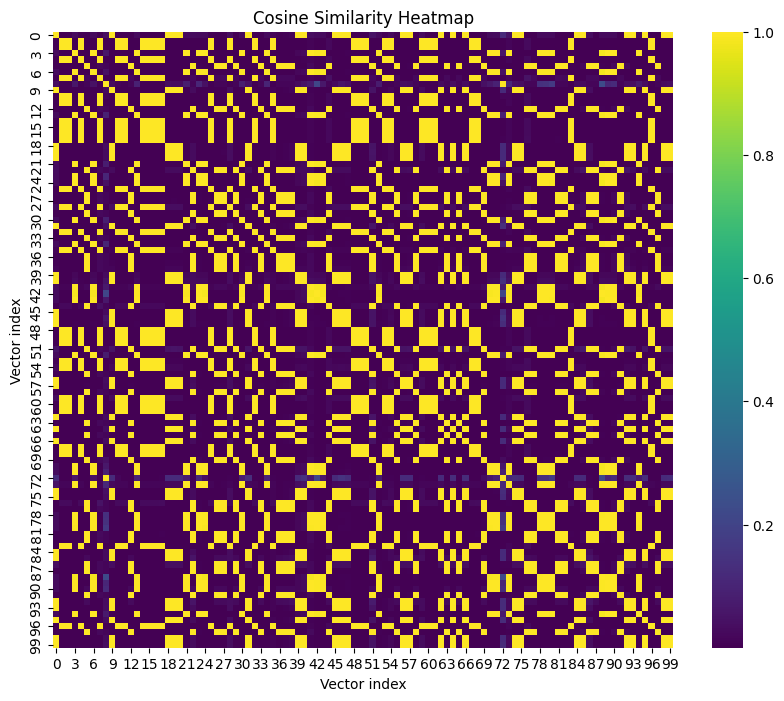

In [74]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# Compute cosine similarity (50 x 50 matrix)
cos_sim = cosine_similarity(user_embeddings)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cos_sim, cmap="viridis", annot=False)
plt.title("Cosine Similarity Heatmap")
plt.xlabel("Vector index")
plt.ylabel("Vector index")
plt.show()

Let's make a UMAP plot instead. This is generally easier to visualize. From our last models, we should be a bit curious to see where users 72 and 8 sit in the pile of data. We can also throw on a label for the average behavior of the target user. 

/Users/walder2/python_envs/dmx_kernel/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/walder2/python_envs/dmx_kernel/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


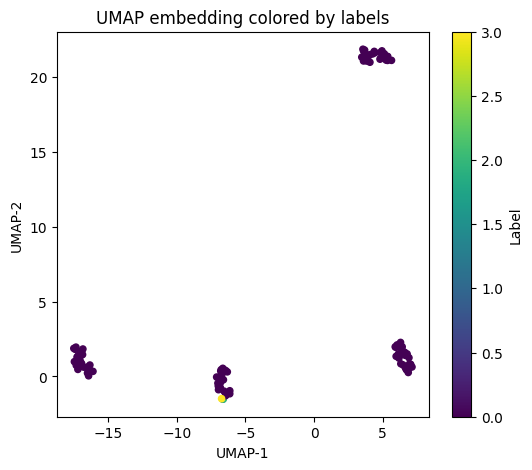

In [75]:
import numpy as np
import umap.umap_ as umap
import matplotlib.pyplot as plt

labels = [0]*100
labels[8] = 1
labels[72] = 2
labels.append(3)

# UMAP embedding
reducer = umap.UMAP(n_components=2, random_state=10)
new_user_embedding = np.mean(mm.seq_posterior(seq_encode(target, model=mm)[0][1]), axis=0)
stacked_embs = np.vstack([user_embeddings, new_user_embedding])
embedding = reducer.fit_transform(stacked_embs)

# Scatter with labels as colors
plt.figure(figsize=(6, 5))
scatter = plt.scatter(
    embedding[:, 0],
    embedding[:, 1],
    c=np.asarray(labels),
    s=20
)
plt.xlabel("UMAP-1")
plt.ylabel("UMAP-2")
plt.title("UMAP embedding colored by labels")
plt.colorbar(scatter, label="Label")
plt.show()

It looks like users 72 and 8 are sitting near the target user. Perhaps those are the aliases of the target user? 

In [76]:
enc_target = seq_encode(target, model=mm)[0][1]

ll = mm.seq_component_log_density(enc_target)
ll_max = np.max(ll, axis=1, keepdims=True)
ll -= ll_max
np.exp(ll, out=ll)
ll = np.log(ll @ user_embeddings.T) + ll_max

hmm_top_5 = np.argsort(-ll, axis=1)[:, :5]


for i in range(5):
    print(f"Top 5 for document {i}: {hmm_top_5[i].tolist()}")

Top 5 for document 0: [8, 72, 88, 42, 80]
Top 5 for document 1: [8, 72, 88, 42, 80]
Top 5 for document 2: [8, 72, 88, 42, 80]
Top 5 for document 3: [8, 72, 88, 42, 80]
Top 5 for document 4: [8, 72, 88, 42, 80]


And there you have it! Users 8 and 72 are sitting right in the top 2 nearest neighbors for each document from the target user.